# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotli# Importb.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [1]:
import sklearn
import sklearn.preprocessing
import datetime
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import warnings
warnings.filterwarnings(action='ignore')

Instructions for updating:
non-resource variables are not supported in the long term


# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [2]:
path = "./Dataset/"

# original data : data 
data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기
data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터  
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 나눌 수 있겠습니다. 

**4. converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing 

**9,327 rows × 66 columns**

**9,327 rows × 5 columns**

**===================Default 하게 진행======================**

RNN, LSTM 모델에서는 converting features 사용할 예정  
각각의 converting data가 가지는 길이가 다르기 때문에 sig1, sig2, sig3... sig5 data로 나누어 사용할 것  

**feature processing**
- astype : float 
- sig1_data, sig2_data, sig3_data, sig4_data, sig5_data 
    - CONVERT(activity_class_5min USING utf8)    
    - CONVERT(activity_met_1min USING utf8)      
    - CONVERT(sleep_hr_5min USING utf8)          
    - CONVERT(sleep_hypnogram_5min USING utf8)  
    - CONVERT(sleep_rmssd_5min USING utf8) 

**=========================Y Varible=========================**

- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding 
    - 모델마다 y 변수를 자동으로 label encoding 기능을 지원하기도 하지만 공통적으로 진행하고 넘어갑시다
    
So we may use 5 columns for training...

In [14]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = data.copy()

In [15]:
# Feature Selection - column drop 
# 사용할 column만 잘라냅니다
processed_data = processed_data.iloc[:, 60:66]
# 9327 x 6 

processed_data -> 5개의 sig1_data, sig2_data, sig3_data, sig4_data, sig5_data 으로 변환

In [36]:
# signal 01
signal_list = list(processed_data['CONVERT(activity_class_5min USING utf8)'].str.split('/'))
sig1_data = pd.DataFrame(signal_list).drop(288, axis=1).astype('float')

sig1_data # 9327 x 288

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9323,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9324,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9325,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [35]:
# signal 02
signal_list = list(processed_data['CONVERT(activity_met_1min USING utf8)'].str.split('/'))
sig2_data = pd.DataFrame(signal_list).drop(1440, axis=1).astype('float')

sig2_data # 9327 x 1440

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.9,0.9,1.4,1.9,1.1,0.9,0.9,1.1,1.3,1.0,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
1,1.2,1.1,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
2,1.1,1.1,1.2,1.1,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.1,1.4,1.2,0.9,1.2,1.1,0.9,0.9,0.9,1.0,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9323,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9324,0.9,0.9,0.9,0.9,1.1,0.9,0.9,1.1,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
9325,1.1,0.9,0.9,0.9,1.0,0.9,0.9,0.9,0.9,0.9,...,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [34]:
# signal 03
signal_list = list(processed_data['CONVERT(sleep_hr_5min USING utf8)'].str.split('/'))
sig3_data = pd.DataFrame(signal_list).drop(181, axis=1).transpose() # 결측치 처리를 위한 transpose 

# 결측치 처리 Nan, '', ' ' -> 0으로 replace 
sig3_data = sig3_data.fillna(0) 
sig3_data = sig3_data.replace('', 0)
sig3_data = sig3_data.replace(' ', 0)
sig3_data = sig3_data.astype('float').transpose() # 되돌리기 

sig3_data # 9327 x 181

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.0,73.0,73.0,73.0,72.0,71.0,70.0,71.0,71.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69.0,70.0,69.0,69.0,70.0,72.0,71.0,72.0,70.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,74.0,73.0,73.0,74.0,74.0,74.0,71.0,71.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.0,70.0,71.0,72.0,75.0,75.0,73.0,70.0,70.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,0.0,54.0,54.0,54.0,55.0,56.0,0.0,0.0,55.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9323,68.0,66.0,67.0,67.0,68.0,69.0,69.0,70.0,71.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,0.0,0.0,65.0,65.0,66.0,67.0,69.0,72.0,73.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,0.0,0.0,0.0,64.0,64.0,64.0,64.0,65.0,65.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# signal 04
signal_list = list(processed_data['CONVERT(sleep_hypnogram_5min USING utf8)'].str.split('/'))
sig4_data = pd.DataFrame(signal_list).drop(180, axis=1).transpose() # 결측치 처리를 위한 transpose 

# 결측치 처리 Nan, '', ' ' -> 0으로 replace 
sig4_data = sig4_data.fillna(0) 
sig4_data = sig4_data.replace('', 0)
sig4_data = sig4_data.replace(' ', 0)
sig4_data = sig4_data.astype('float').transpose() # 되돌리기 

sig4_data # 9327 x 180

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,4.0,2.0,4.0,3.0,3.0,1.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,4.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,2.0,4.0,4.0,1.0,1.0,1.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,4.0,4.0,4.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9323,4.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,4.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# signal 05
signal_list = list(processed_data['CONVERT(sleep_rmssd_5min USING utf8)'].str.split('/'))
sig5_data = pd.DataFrame(signal_list).drop(181, axis=1).transpose() # 결측치 처리를 위한 transpose 

# 결측치 처리 Nan, '', ' ' -> 0으로 replace 
sig5_data = sig5_data.fillna(0) 
sig5_data = sig5_data.replace('', 0)
sig5_data = sig5_data.replace(' ', 0)
sig5_data = sig5_data.astype('float').transpose() # 되돌리기 

sig5_data # 9327 x 181

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.0,10.0,10.0,10.0,11.0,11.0,10.0,12.0,18.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.0,23.0,26.0,24.0,18.0,13.0,15.0,14.0,17.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,11.0,14.0,20.0,13.0,14.0,14.0,16.0,27.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24.0,28.0,19.0,17.0,12.0,10.0,17.0,20.0,23.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,0.0,35.0,39.0,28.0,26.0,41.0,0.0,0.0,52.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9323,26.0,16.0,19.0,18.0,16.0,18.0,19.0,17.0,15.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,0.0,0.0,13.0,12.0,12.0,13.0,12.0,12.0,12.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,0.0,0.0,0.0,14.0,17.0,18.0,14.0,14.0,17.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Data Split + y Variable Processing 

모든 전처리와 y variable labeling이 완료되었다.  
train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자.

- **3d - array 처리** 
    - Sequential model 의 input layer에는 ndarray 데이터만 들어가야 함
- **y 변수 두 가지로 encoding** 
    - Label Encoding (le) -> sparse_categorical_crossentropy 실험 
    - One Hot Encoding (ohe) -> categorical_crossentropy 실험 
- **train / test** 
    - Sequential model option 중 validation dataset을 자동으로 나눠주는 것이 존재 하므로 


- 즉 다음과 같은 조합이 하나의 dataset 이며  
    - input_data_X1 + input_data_y_le + input_data_y_ohe
    - 실험은 한 모델당 두 가지 y 변수로 2번 실험하면 됨
    - **inpu_data_X1_le + input_data_y_le**
    - **inpu_data_X1_ohe + input_data_y_ohe**

In [54]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# data를 따로 관리
# preprocessing data -> processed_data
# input data -> input_data => y 변수와 X 변수 분할 관리 
input_data_X1 = sig1_data.copy()
input_data_X2 = sig2_data.copy()
input_data_X3 = sig3_data.copy()
input_data_X4 = sig4_data.copy()
input_data_X5 = sig5_data.copy()

input_data_y = processed_data['DIAG_NM'] .copy()

In [55]:
# 3d-array 처리 - X variables 
input_data_X1 =  input_data_X1.to_numpy().reshape(input_data_X1.shape[0], input_data_X1.shape[1], 1)
input_data_X2 =  input_data_X2.to_numpy().reshape(input_data_X2.shape[0], input_data_X2.shape[1], 1)
input_data_X3 =  input_data_X3.to_numpy().reshape(input_data_X3.shape[0], input_data_X3.shape[1], 1)
input_data_X4 =  input_data_X4.to_numpy().reshape(input_data_X4.shape[0], input_data_X4.shape[1], 1)
input_data_X5 =  input_data_X5.to_numpy().reshape(input_data_X5.shape[0], input_data_X5.shape[1], 1)

In [56]:
# LabelEncoder - y variable 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y_label = le.fit_transform(list(input_data_y))

print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y_label))

input_data_y_label

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [57]:
# One Hot Encdoer - y variable 
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

input_data_y.shape
input_data_y.values.reshape(-1,1).shape
ohe.fit(input_data_y.values.reshape(-1,1))
one_hot_encoded = ohe.transform(input_data_y.values.reshape(-1,1))

print(type(ohe.categories_))
print(ohe.categories_)

input_data_y_ohe = pd.DataFrame(one_hot_encoded, columns=ohe.categories_[0])
input_data_y_ohe

<class 'list'>
[array(['CN', 'Dem', 'MCI'], dtype=object)]


,CN,Dem,MCI
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
9322,1.0,0.0,0.0
9323,1.0,0.0,0.0
9324,1.0,0.0,0.0
9325,1.0,0.0,0.0


In [58]:
X1_train_label, X1_test_label, y1_train_label, y1_test_label = train_test_split(
    input_data_X1, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X2_train_label, X2_test_label, y2_train_label, y2_test_label = train_test_split(
    input_data_X2, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X3_train_label, X3_test_label, y3_train_label, y3_test_label = train_test_split(
    input_data_X3, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X4_train_label, X4_test_label, y4_train_label, y4_test_label = train_test_split(
    input_data_X4, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X5_train_label, X5_test_label, y5_train_label, y5_test_label = train_test_split(
    input_data_X5, input_data_y_label, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)

In [59]:
X1_train_ohe, X1_test_ohe, y1_train_ohe, y1_test_ohe = train_test_split(
    input_data_X1, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X2_train_ohe, X2_test_ohe, y2_train_ohe, y2_test_ohe = train_test_split(
    input_data_X2, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X3_train_ohe, X3_test_ohe, y3_train_ohe, y3_test_ohe = train_test_split(
    input_data_X3, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X4_train_ohe, X4_test_ohe, y4_train_ohe, y4_test_ohe = train_test_split(
    input_data_X4, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)
X5_train_ohe, X5_test_ohe, y5_train_ohe, y5_test_ohe = train_test_split(
    input_data_X5, input_data_y_ohe, test_size=0.2, shuffle=True, stratify=input_data_y, random_state=2022)

In [61]:
# 데이터가 잘 분할되었을까요?
# 잘 분할되었습니다 
# 7461 + 1866 = 9327
print("X1_train_label :" ,X1_train_label.shape)
print("X1_train_ohe :" ,X1_train_ohe.shape)
print("y1_train_label :" ,y1_train_label.shape)
print("y1_train_ohe :" ,y1_train_ohe.shape)
print("X1_test_label :" ,X1_test_label.shape)
print("X1_test_ohe :" ,X1_test_ohe.shape)
print("y1_test_label :" ,y1_test_label.shape)
print("y1_test_ohe :" ,y1_test_ohe.shape)

X1_train_label : (7461, 288, 1)
X1_train_ohe : (7461, 288, 1)
y1_train_label : (7461,)
y1_train_ohe : (7461, 3)
X1_test_label : (1866, 288, 1)
X1_test_ohe : (1866, 288, 1)
y1_test_label : (1866,)
y1_test_ohe : (1866, 3)


# 5. Modeling - DL 

- **simple RNN** 
    - ohe **0.638**
    - le **0.639**
- **multi-layer RNN**
    - ohe 0.637
    - le 0.637
- **simple LSTM**
    - ohe 
    - le 
- **multi-layer LSTM**
    - ohe 
    - le 

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Activation, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from keras import optimizers
from sklearn.metrics import accuracy_score
from keras.layers import Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

In [124]:
# hyperparameters
units = 50
timesteps = 1
inputs = (X3_train_ohe.shape[1],X3_train_ohe.shape[2])
outputs = 3
epochs = 1000
batch_size = 256
# early_stop 하기 위해 관찰 값 monitor
# 관찰 값이 loss 이므로 최소화 시키는 방향으로 training이 진행 (default 깂 Auto)
# patience : 성능이 증가하지 않더라도 epoch을 얼마나 더 진행해볼 것인가?
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min'
                               , patience=100, verbose=1)

### simple RNN

In [125]:
def vanilla_rnn():
    model = Sequential()
    model.add(SimpleRNN(units, input_shape = inputs, return_sequences = False)) 
    model.add(Dense(outputs)) #target 개수 = 3
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    #y를 one-hot encoding 시 'categorical_crossentropy 사용
    #y를 label encoding 시 'sparse_categorical_crossentropy' 사용
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy']) 
    
    return model

In [126]:
# one-hot encoding으로 fit
signle_rnn_model = KerasClassifier(build_fn = vanilla_rnn
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
hist = signle_rnn_model.fit(X3_train_ohe, y3_train_ohe)
y3_pred_rnn_ohe = signle_rnn_model.predict(X3_test_ohe)

Epoch 1/1000
24/24 [==============================] - 2s 41ms/step - loss: 0.9879 - accuracy: 0.4967 - val_loss: 0.8335 - val_accuracy: 0.6450
Epoch 2/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8285 - accuracy: 0.6364 - val_loss: 0.8298 - val_accuracy: 0.6450
Epoch 3/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8257 - accuracy: 0.6436 - val_loss: 0.8300 - val_accuracy: 0.6457
Epoch 4/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8293 - accuracy: 0.6347 - val_loss: 0.8278 - val_accuracy: 0.6450
Epoch 5/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.8304 - accuracy: 0.6356 - val_loss: 0.8256 - val_accuracy: 0.6450
Epoch 6/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.8250 - accuracy: 0.6377 - val_loss: 0.8220 - val_accuracy: 0.6457
Epoch 7/1000
24/24 [==============================] - 1s 32ms/step - loss: 1.0839 - accuracy: 0.5180 - val_loss: 0.8241 - val_accuracy: 0.6450

Epoch 58/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8210 - accuracy: 0.6421 - val_loss: 0.8268 - val_accuracy: 0.6457
Epoch 59/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.8096 - accuracy: 0.6545 - val_loss: 0.8265 - val_accuracy: 0.6457
Epoch 60/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8225 - accuracy: 0.6366 - val_loss: 0.8264 - val_accuracy: 0.6457
Epoch 61/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.8125 - accuracy: 0.6459 - val_loss: 0.8269 - val_accuracy: 0.6457
Epoch 62/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8226 - accuracy: 0.6392 - val_loss: 0.8259 - val_accuracy: 0.6457
Epoch 63/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8185 - accuracy: 0.6461 - val_loss: 0.8299 - val_accuracy: 0.6457
Epoch 64/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.8284 - accuracy: 0.6355 - val_loss: 0.8258 - val_accuracy:

Epoch 115/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8072 - accuracy: 0.6427 - val_loss: 0.7998 - val_accuracy: 0.6470
Epoch 116/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.8021 - accuracy: 0.6423 - val_loss: 0.8011 - val_accuracy: 0.6470
Epoch 117/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8039 - accuracy: 0.6446 - val_loss: 0.8041 - val_accuracy: 0.6457
Epoch 118/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.7992 - accuracy: 0.6418 - val_loss: 0.8047 - val_accuracy: 0.6450
Epoch 119/1000
24/24 [==============================] - 1s 34ms/step - loss: 0.8115 - accuracy: 0.6381 - val_loss: 0.8020 - val_accuracy: 0.6477
Epoch 120/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8094 - accuracy: 0.6421 - val_loss: 0.7989 - val_accuracy: 0.6450
Epoch 121/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8060 - accuracy: 0.6455 - val_loss: 0.8022 - val_ac

24/24 [==============================] - 1s 32ms/step - loss: 0.7938 - accuracy: 0.6458 - val_loss: 0.8004 - val_accuracy: 0.6450
Epoch 172/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.7968 - accuracy: 0.6414 - val_loss: 0.7972 - val_accuracy: 0.6457
Epoch 173/1000
24/24 [==============================] - 1s 33ms/step - loss: 0.7916 - accuracy: 0.6473 - val_loss: 0.8004 - val_accuracy: 0.6457
Epoch 174/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.7988 - accuracy: 0.6443 - val_loss: 0.7983 - val_accuracy: 0.6457
Epoch 175/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8055 - accuracy: 0.6384 - val_loss: 0.7994 - val_accuracy: 0.6463
Epoch 176/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.7981 - accuracy: 0.6391 - val_loss: 0.7994 - val_accuracy: 0.6457
Epoch 177/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8015 - accuracy: 0.6456 - val_loss: 0.8029 - val_accuracy: 0.6463


24/24 [==============================] - 1s 31ms/step - loss: 0.8204 - accuracy: 0.6274 - val_loss: 0.8008 - val_accuracy: 0.6450
Epoch 228/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.8040 - accuracy: 0.6375 - val_loss: 0.8007 - val_accuracy: 0.6470
Epoch 229/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.7941 - accuracy: 0.6404 - val_loss: 0.7992 - val_accuracy: 0.6457
Epoch 230/1000
24/24 [==============================] - 1s 32ms/step - loss: 0.8060 - accuracy: 0.6409 - val_loss: 0.7987 - val_accuracy: 0.6457
Epoch 231/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.7975 - accuracy: 0.6450 - val_loss: 0.8006 - val_accuracy: 0.6450
Epoch 232/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.7976 - accuracy: 0.6434 - val_loss: 0.8015 - val_accuracy: 0.6450
Epoch 233/1000
24/24 [==============================] - 1s 31ms/step - loss: 0.7998 - accuracy: 0.6398 - val_loss: 0.8009 - val_accuracy: 0.6443


C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 0s 14ms/step


In [127]:
print("RNN accouracy : ", accuracy_score(y3_pred_rnn_ohe,y3_test_label))

RNN accouracy :  0.6355841371918542


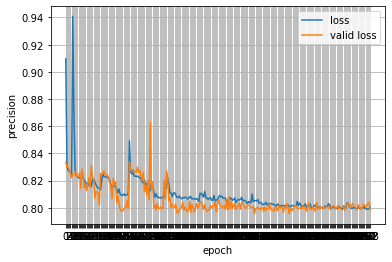

In [128]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.xticks(range(len(hist.history['loss'])))
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [67]:
# label encoding으로 fit
signle_rnn_model.fit(X3_train_label, y3_train_label)
y3_pred_rnn_label = signle_rnn_model.predict(X3_test_label)

Epoch 1/50
24/24 [==============================] - 2s 47ms/step - loss: 0.9497 - accuracy: 0.5448 - val_loss: 0.8362 - val_accuracy: 0.6457
Epoch 2/50
24/24 [==============================] - 1s 36ms/step - loss: 0.8267 - accuracy: 0.6392 - val_loss: 0.8301 - val_accuracy: 0.6430
Epoch 3/50
24/24 [==============================] - 1s 36ms/step - loss: 0.8354 - accuracy: 0.6375 - val_loss: 0.8410 - val_accuracy: 0.6390
Epoch 4/50
24/24 [==============================] - 1s 35ms/step - loss: 0.8328 - accuracy: 0.6327 - val_loss: 0.8339 - val_accuracy: 0.6450
Epoch 5/50
24/24 [==============================] - 1s 36ms/step - loss: 0.8349 - accuracy: 0.6392 - val_loss: 0.8323 - val_accuracy: 0.6450
Epoch 6/50
24/24 [==============================] - 1s 35ms/step - loss: 0.8278 - accuracy: 0.6386 - val_loss: 0.8329 - val_accuracy: 0.6450
Epoch 7/50
24/24 [==============================] - 1s 36ms/step - loss: 0.8291 - accuracy: 0.6389 - val_loss: 0.8312 - val_accuracy: 0.6450
Epoch 8/50
24

C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 0s 11ms/step


In [68]:
print("RNN accouracy : ", accuracy_score(y3_pred_rnn_label,y3_test_label))

RNN accouracy :  0.6387995712754555


### multi-layer RNN

In [69]:
def stacked_vanilla_rnn():
    model = Sequential()
    # return_sequences parameter has to be set True to stack
    model.add(SimpleRNN(units, input_shape = inputs, return_sequences = True))   
    model.add(SimpleRNN(units, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [70]:
# one-hot encoding으로 fit
multi_rnn_model = KerasClassifier(build_fn = stacked_vanilla_rnn
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
multi_rnn_model.fit(X3_train_ohe, y3_train_ohe)
y3_pred_multi_rnn_ohe = multi_rnn_model.predict(X3_test_ohe)

Epoch 1/50
24/24 [==============================] - 4s 96ms/step - loss: 0.9325 - accuracy: 0.5639 - val_loss: 0.8324 - val_accuracy: 0.6423
Epoch 2/50
24/24 [==============================] - 2s 82ms/step - loss: 0.8337 - accuracy: 0.6318 - val_loss: 0.8291 - val_accuracy: 0.6450
Epoch 3/50
24/24 [==============================] - 2s 82ms/step - loss: 0.8472 - accuracy: 0.6268 - val_loss: 0.8164 - val_accuracy: 0.6443
Epoch 4/50
24/24 [==============================] - 2s 83ms/step - loss: 0.8311 - accuracy: 0.6316 - val_loss: 0.8206 - val_accuracy: 0.6443
Epoch 5/50
24/24 [==============================] - 2s 81ms/step - loss: 0.8195 - accuracy: 0.6388 - val_loss: 0.8207 - val_accuracy: 0.6484
Epoch 6/50
24/24 [==============================] - 2s 74ms/step - loss: 0.8182 - accuracy: 0.6399 - val_loss: 0.8072 - val_accuracy: 0.6457
Epoch 7/50
24/24 [==============================] - 2s 80ms/step - loss: 0.8228 - accuracy: 0.6326 - val_loss: 0.8129 - val_accuracy: 0.6470
Epoch 8/50
24

C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 0s 29ms/step


In [71]:
print("accouracy : ", accuracy_score(y3_pred_multi_rnn_ohe,y3_test_label))

accouracy :  0.6366559485530546


In [72]:
# Label encoding으로 fit
multi_rnn_model.fit(X3_train_label, y3_train_label)
y3_pred_multi_rnn_label = multi_rnn_model.predict(X3_test_label)

Epoch 1/50
24/24 [==============================] - 4s 88ms/step - loss: 0.9754 - accuracy: 0.5159 - val_loss: 0.8295 - val_accuracy: 0.6463
Epoch 2/50
24/24 [==============================] - 2s 76ms/step - loss: 0.8237 - accuracy: 0.6402 - val_loss: 0.8255 - val_accuracy: 0.6463
Epoch 3/50
24/24 [==============================] - 2s 73ms/step - loss: 0.8180 - accuracy: 0.6409 - val_loss: 0.8066 - val_accuracy: 0.6470
Epoch 4/50
24/24 [==============================] - 2s 73ms/step - loss: 0.8216 - accuracy: 0.6369 - val_loss: 0.8292 - val_accuracy: 0.6457
Epoch 5/50
24/24 [==============================] - 2s 76ms/step - loss: 0.8220 - accuracy: 0.6479 - val_loss: 0.8294 - val_accuracy: 0.6470
Epoch 6/50
24/24 [==============================] - 2s 79ms/step - loss: 0.8183 - accuracy: 0.6404 - val_loss: 0.8290 - val_accuracy: 0.6470
Epoch 7/50
24/24 [==============================] - 2s 79ms/step - loss: 0.8212 - accuracy: 0.6434 - val_loss: 0.8267 - val_accuracy: 0.6463
Epoch 8/50
24

C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 0s 29ms/step


In [73]:
print("accouracy : ", accuracy_score(y3_pred_multi_rnn_label,y3_test_label))

accouracy :  0.6366559485530546


### simple LSTM

In [75]:
def lstm():
    model = Sequential()
    model.add(LSTM(units, input_shape = inputs, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [76]:
# one-hot encoding으로 fit
single_lstm_model = KerasClassifier(build_fn = lstm
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
single_lstm_model.fit(X3_train_ohe, y3_train_ohe)
y3_pred_single_lstm = single_lstm_model.predict(X3_test_ohe)

Epoch 1/50
24/24 [==============================] - 5s 141ms/step - loss: 1.0635 - accuracy: 0.5872 - val_loss: 0.8383 - val_accuracy: 0.6450
Epoch 2/50
24/24 [==============================] - 3s 117ms/step - loss: 0.8186 - accuracy: 0.6407 - val_loss: 0.8085 - val_accuracy: 0.6457
Epoch 3/50
24/24 [==============================] - 3s 119ms/step - loss: 0.8126 - accuracy: 0.6374 - val_loss: 0.8010 - val_accuracy: 0.6443
Epoch 4/50
24/24 [==============================] - 3s 124ms/step - loss: 0.8122 - accuracy: 0.6353 - val_loss: 0.8005 - val_accuracy: 0.6470
Epoch 5/50
24/24 [==============================] - 3s 124ms/step - loss: 0.8164 - accuracy: 0.6313 - val_loss: 0.8008 - val_accuracy: 0.6463
Epoch 6/50
24/24 [==============================] - 3s 123ms/step - loss: 0.8148 - accuracy: 0.6274 - val_loss: 0.7979 - val_accuracy: 0.6457
Epoch 7/50
24/24 [==============================] - 3s 120ms/step - loss: 0.8081 - accuracy: 0.6378 - val_loss: 0.7936 - val_accuracy: 0.6463
Epoch 

C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 1s 34ms/step


In [77]:
print("accouracy : ", accuracy_score(y3_pred_single_lstm,y3_test_label))

accouracy :  0.6387995712754555


### Single Layer LSTM (Label encoding)

In [44]:
# label encoding으로 fit
single_lstm_model.fit(X3_train_label, y3_train_label)
y3_pred_single_lstm_label = single_lstm_model.predict(X3_test_label)

Train on 5968 samples, validate on 1493 samples
Epoch 1/50
5968/5968 [==============================] - 3s 515us/sample - loss: 0.9884 - acc: 0.6344 - val_loss: 0.8277 - val_acc: 0.6450
Epoch 2/50
5968/5968 [==============================] - 3s 457us/sample - loss: 0.8247 - acc: 0.6387 - val_loss: 0.8124 - val_acc: 0.6463
Epoch 3/50
5968/5968 [==============================] - 3s 438us/sample - loss: 0.8157 - acc: 0.6386 - val_loss: 0.8060 - val_acc: 0.6470
Epoch 4/50
5968/5968 [==============================] - 3s 444us/sample - loss: 0.8165 - acc: 0.6384 - val_loss: 0.8036 - val_acc: 0.6470
Epoch 5/50
5968/5968 [==============================] - 3s 445us/sample - loss: 0.8133 - acc: 0.6377 - val_loss: 0.8029 - val_acc: 0.6470
Epoch 6/50
5968/5968 [==============================] - 3s 439us/sample - loss: 0.8148 - acc: 0.6381 - val_loss: 0.8012 - val_acc: 0.6470
Epoch 7/50
5968/5968 [==============================] - 3s 444us/sample - loss: 0.8127 - acc: 0.6379 - val_loss: 0.8032 - va

In [45]:
print("accouracy : ", accuracy_score(y3_pred_single_lstm_label,y3_test_label))

accouracy :  0.6377277599142551


## multi layer LSTM

In [46]:
def stacked_lstm():
    model = Sequential()
    model.add(LSTM(units, input_shape = inputs, return_sequences = True))
    model.add(LSTM(units, return_sequences = False))
    model.add(Dense(outputs))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

### Multi Layer LSTM (one-hot encoding)

In [47]:
multi_lstm_model = KerasClassifier(build_fn = stacked_lstm
                        , epochs = epochs, batch_size = batch_size, verbose = 1
                       , validation_split = 0.2, callbacks=[early_stopping])
multi_lstm_model.fit(X3_train_ohe, y3_train_ohe)
y3_pred_multi_lstm = multi_lstm_model.predict(X3_test_ohe)

Train on 5968 samples, validate on 1493 samples
Epoch 1/50
5968/5968 [==============================] - 8s 1ms/sample - loss: 0.9401 - acc: 0.6302 - val_loss: 0.8190 - val_acc: 0.6477
Epoch 2/50
5968/5968 [==============================] - 9s 1ms/sample - loss: 0.8235 - acc: 0.6371 - val_loss: 0.8074 - val_acc: 0.6457
Epoch 3/50
5968/5968 [==============================] - 9s 2ms/sample - loss: 0.8150 - acc: 0.6376 - val_loss: 0.8028 - val_acc: 0.6463
Epoch 4/50
5968/5968 [==============================] - 9s 2ms/sample - loss: 0.8127 - acc: 0.6376 - val_loss: 0.8015 - val_acc: 0.6450
Epoch 5/50
5968/5968 [==============================] - 9s 2ms/sample - loss: 0.8135 - acc: 0.6386 - val_loss: 0.8032 - val_acc: 0.6450
Epoch 6/50
5968/5968 [==============================] - 9s 2ms/sample - loss: 0.8149 - acc: 0.6379 - val_loss: 0.8056 - val_acc: 0.6457
Epoch 7/50
5968/5968 [==============================] - 9s 2ms/sample - loss: 0.8111 - acc: 0.6382 - val_loss: 0.7970 - val_acc: 0.6457


In [48]:
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm,y3_test_label))

LSTM multi  layer accouracy :  0.6371918542336549


### Multi Layer LSTM (Label encoding)

In [49]:
multi_lstm_model.fit(X3_train_label, y3_train_label)
y3_pred_multi_lstm_label = multi_lstm_model.predict(X3_test_label)

Train on 5968 samples, validate on 1493 samples
Epoch 1/50
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.9523 - acc: 0.6139 - val_loss: 0.8372 - val_acc: 0.6457
Epoch 2/50
5968/5968 [==============================] - 9s 2ms/sample - loss: 0.8254 - acc: 0.6371 - val_loss: 0.8178 - val_acc: 0.6477
Epoch 3/50
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8171 - acc: 0.6374 - val_loss: 0.8056 - val_acc: 0.6457
Epoch 4/50
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8138 - acc: 0.6386 - val_loss: 0.8020 - val_acc: 0.6457
Epoch 5/50
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8134 - acc: 0.6386 - val_loss: 0.8017 - val_acc: 0.6470
Epoch 6/50
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8117 - acc: 0.6387 - val_loss: 0.8050 - val_acc: 0.6463
Epoch 7/50
5968/5968 [==============================] - 10s 2ms/sample - loss: 0.8105 - acc: 0.6392 - val_loss: 0.8017 - val_acc: 0

In [50]:
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm_label,y3_test_label))

LSTM multi  layer accouracy :  0.6366559485530546


----------------------------------------------------------------------------

one-hot encoding 결과 비교

In [51]:
print("RNN single layer accouracy : ", accuracy_score(y3_pred_rnn_ohe,y3_test_label))
print("RNN multi  layer accouracy : ", accuracy_score(y3_pred_multi_rnn_ohe,y3_test_label))
print("LSTM single layer accouracy : ", accuracy_score(y3_pred_single_lstm,y3_test_label))
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm,y3_test_label))

RNN single layer accouracy :  0.6382636655948553
RNN multi  layer accouracy :  0.6366559485530546
LSTM single layer accouracy :  0.6404072883172561
LSTM multi  layer accouracy :  0.6371918542336549


label encoding 결과 비교

In [52]:
print("RNN single layer accouracy : ", accuracy_score(y3_pred_rnn_label,y3_test_label))
print("RNN multi  layer accouracy : ", accuracy_score(y3_pred_multi_rnn_label,y3_test_label))
print("LSTM single layer accouracy : ", accuracy_score(y3_pred_single_lstm_label,y3_test_label))
print("LSTM multi  layer accouracy : ", accuracy_score(y3_pred_multi_lstm_label,y3_test_label))

RNN single layer accouracy :  0.6393354769560557
RNN multi  layer accouracy :  0.6361200428724545
LSTM single layer accouracy :  0.6377277599142551
LSTM multi  layer accouracy :  0.6366559485530546


-----------------------------------------------------------------------------